# Title of your assignment

#### Student no : 21627581, 21627868
#### Student name : Mehmet Sezer, Burak Yılmaz



## Table of Content

[Purpose](#purpose)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling for Classification](#classificationmodel)  
[Evaluation](#evaluation)  
[References](#references)   


## Purpose <a class="anchor" id="purpose"></a>

There are some diseases which are hard to diagnose by physicians. For instance, the disease
may be rare and the physician who is responsible, has no experience on that disease.
Or, there may be other diseases with similar symptoms and the physician can not make sure
about her/his diagnosis. Whatever the reason is, this sort of cases typically result in
unnecessary and expensive tests, e.g., blood work, x-rays, MRIs, etc. Besides wasting
valuable resources, putting patients into distressing situations is also an issue. Therefore,
diagnosing a disease by using resources optimally and without sacrifing the healthcare
quality is of great importance.

In this project, we built a machine learning (ML) model to predict possible
diseases for a given patient. Moreover, we developed a Web application to front our
model and allow any physicians to use our model while diagnosing their patients. Our
application will produce a list of possible diseases with their probabilities. The idea here is to
allow the physician start diagnosis process by considering the most possible disease first.

## Data Understanding<a class="anchor" id="data_understanding"></a>

Import needed libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from scipy import stats
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold,train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import joblib

Import dataset

In [2]:
df = pd.read_excel('sdsp_patients.xlsx') 
df.head()

,Disease,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Feature_26,Feature_27,Feature_28,Feature_29,Feature_30,Feature_31,Feature_32,Feature_33,Feature_34,Feature_35,Feature_36,Feature_37,Feature_38,Feature_39,Feature_40,Feature_41,Feature_42,Feature_43,Feature_44,Feature_45,Feature_46,Feature_47,Feature_48,Feature_49,Feature_50
0,Disease_1,Male,28.0,130,96.0,2.0,No,Yes,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Every Day,No Difference,No,Yes,Yes,No,No,No,No,No,No,No,No,No,No,No,0,No,No,No,No,No,No
1,Disease_1,Male,18.0,95,46.0,3.0,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,Every Day,Evenings,Yes,Yes,Yes,No,No,No,No,No,No,No,No,No,Yes,No,0,No,No,No,No,No,No
2,Disease_1,Male,44.0,152,150.0,1.0,No,Yes,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Every Day,No Difference,No,Yes,Yes,Yes,No,No,No,Yes,No,No,No,Yes,No,No,0,No,No,No,No,No,No
3,Disease_1,Male,19.0,112,66.0,18.0,No,No,No,Yes,No,No,No,No,No,Yes,No,No,No,No,No,Yes,No,No,No,No,No,No,Every Day,Evenings,Yes,No,Yes,Yes,No,No,No,No,No,No,No,No,Yes,No,0,No,No,No,No,No,No
4,Disease_1,Male,17.5,105.5,54.0,3.0,No,No,Yes,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,No,No,No,Every Day,Evenings,Yes,Yes,Yes,Yes,No,No,No,No,No,No,No,No,No,No,0,No,No,No,No,Yes,No


Numbers of records and features

In [3]:
records, features = df.shape
print("There are {} features".format(features))
print("There are {} records".format(records))

There are 51 features
There are 400 records


Information for features, we can get non-null count from here

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 51 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Disease     400 non-null    object 
 1   Feature_1   400 non-null    object 
 2   Feature_2   400 non-null    float64
 3   Feature_3   400 non-null    object 
 4   Feature_4   400 non-null    float64
 5   Feature_5   400 non-null    float64
 6   Feature_6   400 non-null    object 
 7   Feature_7   400 non-null    object 
 8   Feature_8   400 non-null    object 
 9   Feature_9   400 non-null    object 
 10  Feature_10  400 non-null    object 
 11  Feature_11  400 non-null    object 
 12  Feature_12  400 non-null    object 
 13  Feature_13  400 non-null    object 
 14  Feature_14  400 non-null    object 
 15  Feature_15  400 non-null    object 
 16  Feature_16  400 non-null    object 
 17  Feature_17  400 non-null    object 
 18  Feature_18  400 non-null    object 
 19  Feature_19  400 non-null    o

Map spaces to None

In [5]:
df = df.replace({r'^\s*$': None}, regex=True)

Change 'Feature_3' column type as 'float64'

In [6]:
df['Feature_3'] = df['Feature_3'].astype('float64')

Prepare data for Django form part.

In [7]:
form_data = {}
categorical_data = {}
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
for i in df.columns:
    col_type = df[i].dtypes
    if(col_type == 'object'):
      values = df[i].dropna().unique()
      if('Yes' in values or 'No' in values):
        form_data[i] = 'yes-no'
      else:
        form_data[i] = 'categorical'
        categorical_data[i] = list(values)
    else:
      form_data[i] = str(col_type)

Statistical informations for numeric features

In [8]:
df.describe()

,Feature_2,Feature_3,Feature_4,Feature_5,Feature_44
count,400.000000,398.000000,400.000000,400.000000,400.000000
mean,29.410125,127.770603,108.104000,23.038050,0.457500
std,14.350309,22.529334,49.526425,24.742478,1.547314
min,10.000000,76.000000,12.000000,0.060000,0.000000
25%,18.000000,110.000000,64.500000,6.000000,0.000000
50%,25.525000,128.000000,108.000000,12.000000,0.000000
75%,38.000000,147.000000,144.000000,36.000000,0.000000
max,90.000000,181.000000,213.000000,168.000000,9.000000


Print unique Disease feature values

In [9]:
df['Disease'].unique()

array(['Disease_1', 'Disease_2', 'Disease_3', 'Disease_4'], dtype=object)

Distribution of Disease feature

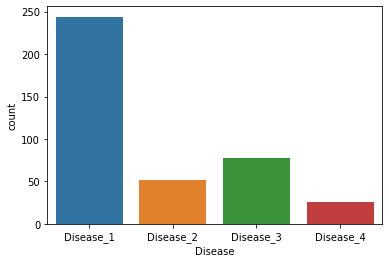

In [10]:
sns.countplot(x=df['Disease'])

## Data Preparation<a class="anchor" id="data_preparation"></a>

Remove columns which have same value in all row

In [11]:
nunique = df.dropna(axis=1).apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
df = df.drop(cols_to_drop, axis=1)

Understand the correlation between features

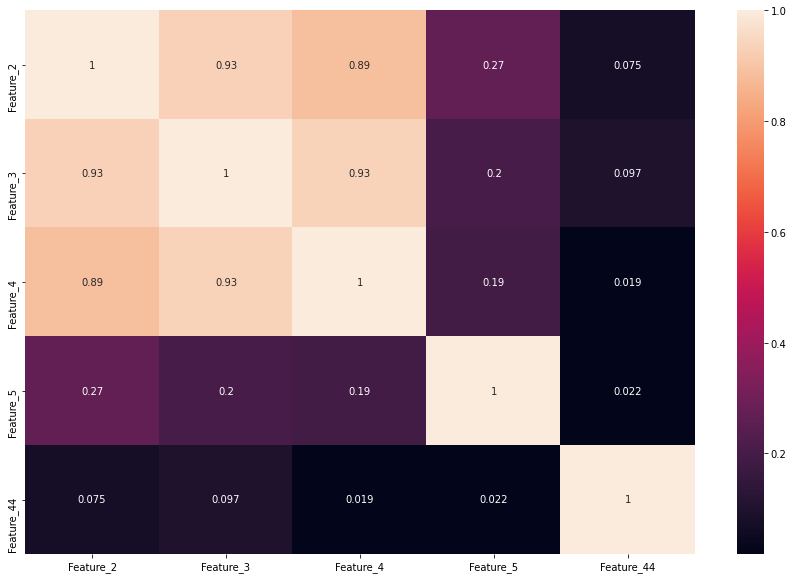

In [12]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True)

Drop high correlation(anyone has correlation to any feature higher than 0.90) features

In [13]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Find features with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

# Drop features 
df.drop(to_drop, axis=1, inplace=True)

**Box plots** are a graphical depiction of numerical data through their quantiles. It is a very simple but effective way to visualize outliers. Think about the lower and upper whiskers as the boundaries of the data distribution. Any data points that show above or below the whiskers, can be considered outliers or anomalous.

As you can see, it considers everything above 75 or below ~ -35 to be an outlier.

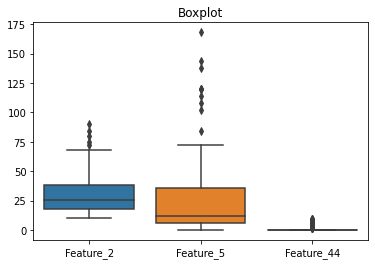

In [14]:
sns.boxplot(data=df) 
plt.title('Boxplot') 
plt.show()

Remove anomalies

In [15]:
df_num = df.select_dtypes(include=['float64', 'int64'])
df = df[(np.abs(stats.zscore(df_num)) < 3).all(axis=1)]

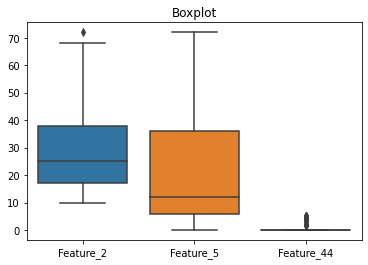

In [16]:
sns.boxplot(data=df)
plt.title('Boxplot')
plt.show()

Map object type features to numeric

In [17]:
df = df.replace({'Yes': 1, 'No': 0, 'Female': 1, 'Male': 0})

Map Diseases feature to numeric values

In [18]:
df['Disease'] = df['Disease'].replace({'Disease_1': 0, 'Disease_2': 1, 'Disease_3': 2, 'Disease_4': 3})

**get_dummies**: Convert categorical variable into dummy/indicator variables.

Get dummies for categorical features

In [19]:
object_col = [col for col in df.columns if df[col].dtype == 'object']
df = pd.get_dummies(data=df, columns=object_col,drop_first=True)

Feature_12 have a lot of repeated "0" value so we can drop this feature

In [20]:
res = {col:df[col].value_counts() for col in df.columns}
res['Feature_12']

0    378
1      1
Name: Feature_12, dtype: int64

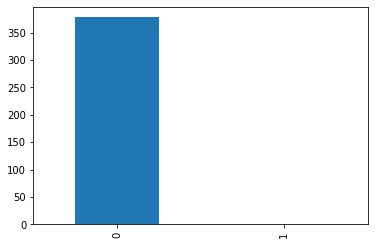

In [21]:
df['Feature_12'].value_counts().plot(kind='bar')
df.drop('Feature_12', inplace=True, axis=1)

None distribution

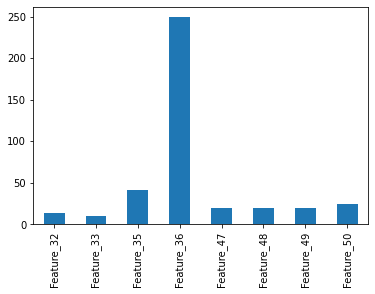

In [22]:
df[df.columns[df.isnull().any()]].isnull().sum().plot.bar()

**KNN Inputer:** Imputation for completing missing values using k-Nearest Neighbors. Each sample’s missing values are imputed using the mean value from n_neighbors nearest neighbors found in the training set. Two samples are close if the features that neither is missing are close.

We used RandomForestClassifier in the pipeline because previous models which we trained, had more accurate with RandomForestClassifier.

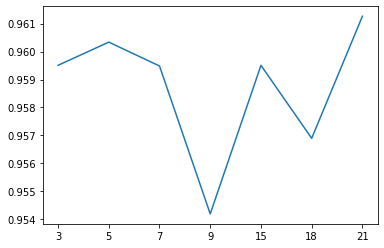

In [23]:
results = list()
strategies = [str(i) for i in [3,5,7,9,15,18,21]]
for s in strategies:
    # create the modeling pipeline
    pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', RandomForestClassifier())])
    # evaluate the model
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, df.iloc[:,1:], df['Disease'], scoring='accuracy', cv=cv, n_jobs=-1)
    # store results
    results.append(np.mean(scores))
# plot model performance for comparison
plt.plot(strategies,results)
plt.show()

In [24]:
imputer = KNNImputer(n_neighbors=int(strategies[results.index(max(results))]))
df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)

In [25]:
df.isna().values.any()

False


## Modeling for Classification <a class="anchor" id="classificationmodel"></a>

Find the best accurate classification algorithm. By looking plots we decided to use RandomForest.

In [26]:
DT_PIPE = Pipeline(steps = [('scale',MinMaxScaler()),('DT',DecisionTreeClassifier(random_state=42))])
RF_PIPE = Pipeline(steps = [('scale',MinMaxScaler()),('DT',RandomForestClassifier(random_state=42))])
SVM_PIPE = Pipeline(steps = [('scale',MinMaxScaler()),('DT',SVC(random_state=42))])
LR_PIPE = Pipeline(steps = [('scale',MinMaxScaler()),('DT',LogisticRegression(random_state=42))])

In [27]:
DT_CROSS_VAL = cross_val_score(DT_PIPE,df.iloc[:,1:],df['Disease'],cv=10)
RF_CROSS_VAL = cross_val_score(RF_PIPE,df.iloc[:,1:],df['Disease'],cv=10)
SVM_CROSS_VAL = cross_val_score(SVM_PIPE,df.iloc[:,1:],df['Disease'],cv=10)
LR_CROSS_VAL = cross_val_score(LR_PIPE,df.iloc[:,1:],df['Disease'],cv=10)

In [28]:
fig = make_subplots(rows=4, cols=1,shared_xaxes=True,subplot_titles=('Decision Tree Cross Val Scores',
                                                                     'RandomForest Cross Val Scores',
                                                                    'SVM Cross Val Scores','Logistic Regression Cross Val Scores'))

fig.add_trace(
    go.Scatter(x=list(range(0,len(DT_CROSS_VAL))),y=DT_CROSS_VAL,name='Decision Tree'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=list(range(0,len(DT_CROSS_VAL))),y=RF_CROSS_VAL,name='RandomForest'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=list(range(0,len(DT_CROSS_VAL))),y=SVM_CROSS_VAL,name='SVM'),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=list(range(0,len(DT_CROSS_VAL))),y=LR_CROSS_VAL,name='Logistic Regression'),
    row=4, col=1
)

fig.update_layout(height=700, width=900, title_text="Different Model 5 Fold Cross Validation")
fig.update_yaxes(title_text="Score")
fig.update_xaxes(title_text="Fold #")

fig.show()

Select top 7 features. We got these features from previous model's most top importance features.

In [29]:
df = df[['Disease','Feature_5','Feature_27','Feature_28_Every Day','Feature_28_1-2 Days a Week', 'Feature_28_3-4 Days a Week','Feature_33','Feature_37','Feature_39', 'Feature_43']]

Split the dataset %70 train and %30 test

**random_state:** Controls the shuffling applied to the data before applying the split. Pass an int for reproducible output across multiple function calls.

**stratify:** If not None, data is split in a stratified fashion, using this as the class labels. We used 'Disease' feature because We want to distribute 'Disease' feature evenly distributed.

Train text split

In [30]:
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,1:],df['Disease'],test_size = 0.3,random_state=1,stratify=df['Disease'], shuffle=True)

Min-Max Normalize

In [31]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

Evaluate cross_val_score to prevent overfitting

cv: Determines the cross-validation splitting strategy. We used 5 so it means it will use (Stratified)KFold with 5 folds

In [32]:
cv = RandomForestClassifier()
accuracies = cross_val_score(estimator = cv, X = x_train, y= y_train, cv = 5)
print("average accuracy: ",np.mean(accuracies))
print("average std: ",np.std(accuracies))

average accuracy:  0.9584905660377359
average std:  0.025031130493248295


We used **Random Forest** for classification because it is more suitable than other algorithms We tried other algorithms such as SVM, Logistic Regression. Random forrest provides more accuracy and reliable model.

**n_estimators**: The number of trees in the forest.

**max_features**: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

**max_depth**: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

**GridSearchCV**: Exhaustive search over specified parameter values for an estimator.

Find best parameters for Random Forrest by using GridSearchCV

In [33]:
# Number of trees in random forest
n_estimators = [100, 200, 300, 500]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [None, 10, 80, 90, 100, 110]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}

rf = RandomForestClassifier()
rf_cv = GridSearchCV(rf, random_grid, cv = 5)
rf_cv.fit(x_train, y_train)

print("Hyperparameter: ",rf_cv.best_params_)
print("Best accuracy:  ",rf_cv.best_score_)

Hyperparameter:  {'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 300}
Best accuracy:   0.9660377358490566


Fit the model with best parameters we found

In [34]:
rf = RandomForestClassifier(
    n_estimators=rf_cv.best_params_["n_estimators"],
    max_depth=rf_cv.best_params_["max_depth"],
    max_features=rf_cv.best_params_["max_features"]
)
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=100, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Evaluation<a class="anchor" id="evaluation"></a>

In statistics, the coefficient of determination, denoted R^2, is the proportion of the variance in the dependent variable that is predictable from the independent variable(s).

R^2 score of model

In [35]:
rf.score(x_test,y_test)

0.9649122807017544

Top 7 feature importances of the model

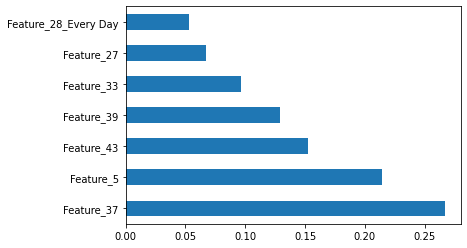

In [36]:
importances = pd.Series(rf.feature_importances_, index=df.iloc[:,1:].columns)
importances.nlargest(7).plot(kind='barh')

**confusion_matrix:** Compute confusion matrix to evaluate the accuracy of a classification. Rows are predicted values columns are actual values so that we can evaluate our model using these informations.

**True Positives (TP):** These are the correctly predicted positive values which means that the value of actual class is yes and the value of predicted class is also yes.

**True Negatives (TN):** These are the correctly predicted negative values which means that the value of actual class is no and value of predicted class is also no.

**False Positives (FP):** When actual class is no and predicted class is yes.

**False Negatives (FN):** When actual class is yes but predicted class in no.

Confusition matrix for model

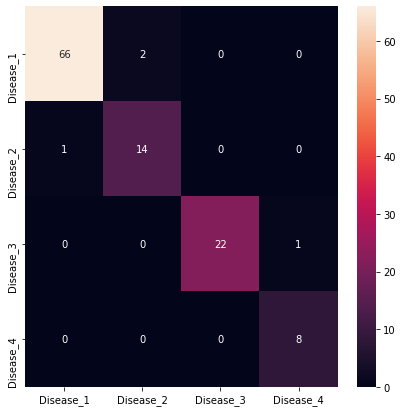

In [37]:
x_pred_test = rf.predict(x_test)
confusiton_matrix_df = pd.DataFrame(confusion_matrix(y_test, x_pred_test), index = [i for i in ['Disease_1', 'Disease_2', 'Disease_3', 'Disease_4']],
                  columns = [i for i in ['Disease_1', 'Disease_2', 'Disease_3', 'Disease_4']])
plt.figure(figsize = (7,7))
sns.heatmap(confusiton_matrix_df, annot=True)

**classification_report:** The classification report visualizer displays the precision, recall, F1, and support scores for the model.

**Precision**: Precision is the ratio of correctly predicted positive observations to the total predicted positive observations.(TP/TP+FP)

**Recall**: Recall is the ratio of correctly predicted positive observations to the all observations in actual class - yes.(TP/TP+FN)

**F1 Score:** The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

**F1** = 2 * (Precision * Recall) / (Precision + Recall)

Classification report for model

In [38]:
print(classification_report(y_test, x_pred_test))

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98        68
         1.0       0.88      0.93      0.90        15
         2.0       1.00      0.96      0.98        23
         3.0       0.89      1.00      0.94         8

    accuracy                           0.96       114
   macro avg       0.94      0.97      0.95       114
weighted avg       0.97      0.96      0.97       114



Dump the model, scaler, and some informations which we need in Django form part to the .pkl file.

In [ ]:
export = {
    'model': rf,
    'model_features': df.drop('Disease',axis=1).columns.values,
    'scaler': scaler,
    'form_data': form_data,
    'categorical_data': categorical_data
}
joblib.dump(export, './django/export.pkl')

## References<a class="anchor" id="references"></a>

[1] https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html

[2] https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/

[3] https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html

[4] https://towardsdatascience.com/boxplot-for-anomaly-detection-9eac783382fd

[5] https://medium.com/@agarwal.vishal819/outlier-detection-with-boxplots-1b6757fafa21

[6] https://medium.com/@venkatasujit272/overview-of-cross-validation-3785d5414ece

[7] https://scikit-learn.org/0.17/modules/generated/sklearn.metrics.r2_score.html

[8] https://vitalflux.com/micro-average-macro-average-scoring-metrics-multi-class-classification-python/

[9] https://medium.com/@kohlishivam5522/understanding-a-classification-report-for-your-machine-learning-model-88815e2ce397

[10] https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

[11] https://towardsdatascience.com/clustering-why-to-use-it-16d8e2fbafe#:~:text=Inertia%20is%20the%20sum%20of,how%20dense%20the%20clusters%20are

[12] https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

[13] https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

[14] https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

[15] https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

[16] https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/


**Disclaimer!** <font color='grey'>This notebook was prepared by <student name(s)> as an assigment for the *BBM469 - Data Intensive Applications Laboratory* class. The notebook is available for educational purposes only. There is no guarantee on the correctness of the content provided as it is a student work.

If you think there is any copyright violation, please let us [know](https://forms.gle/BNNRB2kR8ZHVEREq8). 
</font>